### 1. 異常検知手順の流れ

0. 準備

$M$次元の観測値が$N$個手元にあると仮定する。  
データをまとめて$D$という記号で表し、この中には異常な観測値が含まれていないか、含まれていたとしてもその影響は無視できると仮定する。  
$$
D=\{\boldsymbol{x}^{(1)},\boldsymbol{x}^{(2)},\cdots,\boldsymbol{x}^{(N)}\}
$$

1. ステップ1(分布推定)

データの性質に応じた適切な確率分布のモデルを仮定する。  
パラメータを$\boldsymbol{\theta}$という記号で表す。  
分布推定の問題とは、$p(\boldsymbol{x}|\boldsymbol{\theta})$における未知パラメータ$\boldsymbol{\theta}$を、$D$から決める問題である。

2. ステップ2(異常度の定義)

観測値$\boldsymbol{x}$に対する予測分布を、$p(\boldsymbol{x}|D)$と表す。  
新たな観測値$\boldsymbol{x'}$に対する異常度$a(\boldsymbol{x'})$を、予測分布に対する負の対数尤度、
$$
a(\boldsymbol{x'})=-\ln p(\boldsymbol{x}|D)
$$
で測ることを基本とする。  

3. ステップ3(閾値の設定)

異常度が決まると、それに異常判定のための閾値を付すことで異常検知ができる。
  
ただし、異常度の確率分布を求めるのは簡単なことではなく、正常データ$D$における割合(分位点)を使うのが一般的である。  

### 2. 変数正規分布に基づく異常検知
Davisというデータを使用する。

In [13]:
import pandas as pd

davis = pd.read_csv('C:/Users/tanak/study/参考書/機械学習による異常検知/Davis.csv', index_col=0)
davis.head(3)

,sex,weight,height,repwt,repht
1,M,77,182,77.0,180.0
2,F,58,161,51.0,159.0
3,F,53,161,54.0,158.0


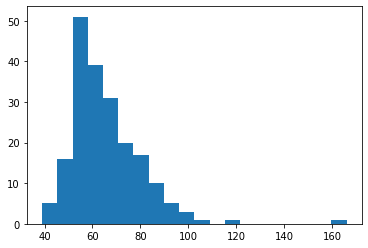

In [24]:
import matplotlib.pyplot as plt

plt.hist(davis['weight'], bins=20);

ステップ1:分布推定  
まずは正規分布をあてはめることを考える。  
確率変数を$x$としたとき、平均$\mu$、分散$\sigma^2$をもつ正規分布は$N(x|\mu,\sigma^2)$は、
$$
N(x|\mu,\sigma^2)=\frac{1}{(2\pi\sigma^2)^{1/2}}\exp\biggl\{-\frac{1}{2\sigma^2}(x-\mu)^2 \biggr\}
$$

この平均$\mu$、分散$\sigma^2$は、データから決めるべきパラメータであり、最尤推定で決定するのが一般的である。  
$$
\hat{\mu}=\frac{1}{N}\sum_{n=1}^Nx^{(n)}\\
\hat{\sigma}^2=\frac{1}{N}\sum_{n=1}^N(x^{(n)}-\hat{\mu})^2
$$

それぞれ、***標本平均**と**標本分散**である。

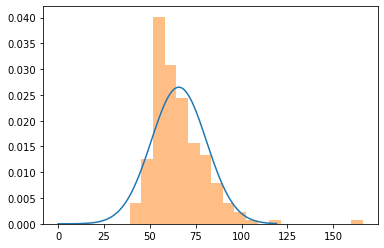

In [57]:
import numpy as np

def NormDist1d(x, mu, sig2):
    return 1/np.sqrt(2*np.pi*sig2) * np.exp(-(x-mu)**2 / (2*sig2))


x = davis['weight']

mu_hat = sum(x) / len(x)
var_hat = sum((x - mu_hat)**2) / len(x)

X = np.arange(0,120)
Y = NormDist1d(X, mu_hat, var_hat)

plt.plot(X, Y);
plt.hist(davis['weight'], bins=20, density=True, alpha=.5);

ステップ2:異常度の定義
ここでは、負の対数尤度を異常度ととして採用することとする。  
$$
\frac{1}{2\hat{\sigma}^2}(x'-\hat{\mu})^2+\frac{1}{2}(2\pi\hat{\sigma}^2)
$$
第2項は観測値$x'$に依存しないので無視し、異常度$a(x')$を次のように定義する。

$$
a(x')=\frac{1}{\hat{\sigma}^2}(x'-\hat{\mu})^2=\biggl(\frac{x'-\hat{\mu}}{\hat{\sigma}} \biggr)^2
$$

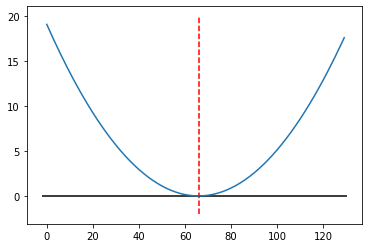

In [75]:
def calc_a(x, mu, var):
    sig = np.sqrt(var)
    return ((x-mu)/sig)**2

X = np.arange(0,130)
a = calc_a(X, mu=mu_hat, var=var_hat)

plt.plot(X, a);
plt.vlines(mu_hat, -2, 20, linestyles='--', color='red');
plt.hlines(0, -2, 130, linestyles='-', color='black');

ステップ3:閾値の設定
異常度の確率分布の導き方として、ホテリング理論が知られている。

>定理1　(ホテリング統計量の分布(1変数))
1次元の観測データ$D=\{x^{(1)},x^{(2)},\cdots,x^{(N)}\}$の各観測値が独立に同じ分布$N(\mu,\sigma^2)$に従い、新たな観測値$x'$も同じ分布に独立に従うとする。このとき、$a(x')$の定数倍は、自由度$(1,N-1)$のF分布に従う。
$$
\frac{N-1}{N+1}a(x')\sim F(1,N-1)
$$
特に、$N\gg 1$のときは、$a(x')$そのものが自由度1、スケール因子1のカイ二乗分布に従う。
$$
a(x')\sim \chi^2(1,1)
$$

$\frac{N-1}{N+1}a(x')$は、ホテリングの統計量(ホテリングの$T^2$)と呼ぶ。

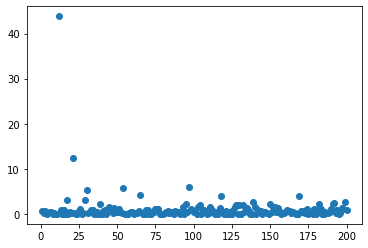

In [127]:
ax = calc_a(x, mu=mu_hat, var=var_hat)
ax = ax*((len(x)-1)/(len(x)+1))

plt.plot(ax, 'o');

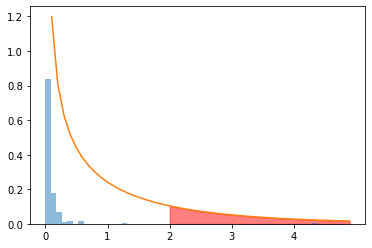

In [148]:
from scipy.stats import f, chi2

plt.hist(ax, bins=50, density=True, alpha=.5);

X = np.arange(0, 5, 0.1)
pf = f.pdf(X, dfn=1, dfd=(len(x)-1));

plt.plot(pf);
plt.fill_between(x=np.arange(20,50), y1=0, y2=f.pdf(np.arange(2,5,0.1), dfn=1, dfd=(len(x)-1)), color='red', alpha=.5)
plt.xticks(np.arange(0,50,10), np.arange(0,5));

例えば、$a(x')=2$がどの程度ありえない値かを判定するには赤色の部分の面積を計算すればよい。  
この面積が小さければ観測値$x'$は正常時にほとんどの確率で0でしか起こらない事象ということになる。  
逆に、この面積をパーセント値で指定すれば、異常値の閾値を決めることができる。

In [123]:
# a(x')=2が起こる確率
1 - f.cdf(2, dfn=1, dfd=(len(x)-1))

0.15886182236023083

In [119]:
# 上側1%点の値
f.ppf(0.99, dfn=1, dfd=(len(x)-1))

6.7639537014327455

#### 実行例
>手順1  
>1. 準備　異常が含まれていないか、含まれていたとしてもごく少数と思われるデータセットを用意する。異常判定の閾値を確率値$\alpha$で与え、カイ二乗分布の表から、異常度の閾値$a_{th}$を求めておく。
>2. ステップ1(分布推定)　標本平均および標本分散
$$
\hat{\mu}=\frac{1}{N}\sum_{n=1}^Nx^{(n)},\ \hat{\sigma}^2\frac{1}{N}\sum_{n=1}^N(x^{(n)}-\hat{\mu})^2
$$
を計算する。
>3. ステップ2(異常度の判定)　新たな観測値$x'$が得られるたび、異常度
$$
a(x')=\biggl(\frac{x'-\hat{\mu}}{\hat{\sigma}} \biggr)^2
$$
の値を計算する。
>4. ステップ3(閾値判定)　異常度が閾値$a_{th}$を超えたら異常と判定する。

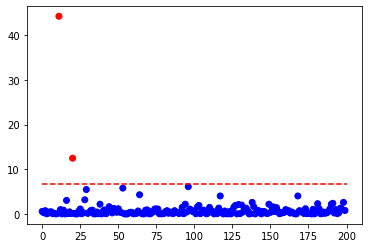

In [161]:
# ステップ1
# カイ二乗分布による1%水準の閾値
ath = chi2.ppf(0.99, df=1)

# ステップ2
x = davis['weight']

mu = np.mean(x)
s2 = np.mean((x - mu_hat)**2)

# ステップ3
a = (x - mu)**2 / s2

# ステップ4
plt.scatter(np.arange(len(x)), a, color = ['red' if a > ath else 'blue' for a in a]);
plt.hlines(ath, xmin=0, xmax=200, linestyles='--', color='red');

### 4 .多変量正規分布に基づく異常検知
ホテリング理論を2つ以上の変数がある場合に拡張する。  
独立に同じ分布に従う$M$次元の$N$個の観測値からなるデータ$D$を考える。  
このデータを、多次元正規分布
$$
N(\boldsymbol{x}|\boldsymbol{\mu},\Sigma)=\frac{|\Sigma|^{-1/2}}{(2\pi)^{M/2}}\exp\biggl\{-\frac{1}{2}(\boldsymbol{x}-\boldsymbol{\mu})^T\Sigma(\boldsymbol{x}-\boldsymbol{\mu}) \biggr\}
$$
によりモデル化する。  
ここで、$\boldsymbol{\mu}$は平均ベクトル、$\Sigma$は共分散行列である。  
  
ステップ1:多次元正規分布の最尤推定
$D$に基づく未知パラメータの対数尤度$L(\boldsymbol{\mu},\Sigma | D)$は次のようになる。
$$
L(\boldsymbol{\mu},\Sigma | D)=\ln\prod_{n=1}^N
N(\boldsymbol{x}|\boldsymbol{\mu},\Sigma)=\sum_{n=1}^NN(\boldsymbol{x}|\boldsymbol{\mu},\Sigma)
$$

これを最大化する$\boldsymbol{\mu}$、$\Sigma$を求めるには、それぞれで微分してゼロと等値した式を解く。
$$
\hat{\boldsymbol{\mu}}=\frac{1}{N}\sum_{n=1}^N\boldsymbol{x}^{(n)}\\
\hat{\Sigma}=\frac{1}{N}\sum_{n=1}^N(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})^T
$$

ステップ2:異常度の定義  
1変数の場合と同様に、負の対数尤度$-\ln N(\boldsymbol{x}|\boldsymbol{\mu},\Sigma)$の2倍をもとに次のように定義する。
$$
a(\boldsymbol{x'})=(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})^T\hat{\Sigma}^{-1}(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})
$$
これを、**マハラノビス距離**(の2乗)と呼ぶこともある。
  
ステップ3:閾値の設定(ホテリングの$T^2$理論)  

>定理2　(多変数のホテリングの$T^2$理論)  
$M$次元正規分布$N(\boldsymbol{\mu},\Sigma)$からの$N$個の独立標本$\{\boldsymbol{x}^{(1)},\cdots,\boldsymbol{x}^{(N)} \}$に基づき、標本平均$\boldsymbol{\mu}$、標本分散$\Sigma$を、
$$
\hat{\boldsymbol{\mu}}=\frac{1}{N}\sum_{n=1}^N\boldsymbol{x}^{(n)}\\
\hat{\Sigma}=\frac{1}{N}\sum_{n=1}^N(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})(\boldsymbol{x}^{(n)}-\hat{\boldsymbol{\mu}})^T
$$
と定義する。  
$N(\boldsymbol{\mu},\Sigma)$からの独立標本$\boldsymbol{x'}$を新たに観測したとき、以下が成立する。
>1. $\boldsymbol{x'}-\hat{\boldsymbol{\mu}}$は、平均$\boldsymbol{0}$、共分散$\frac{N+1}{N}\Sigma$の$M$次元正規分布に従う。
>2. $N\hat{\Sigma}$は、$\boldsymbol{x'}-\hat{\boldsymbol{\mu}}$と統計的に独立に、自由度$N-1$、スケール行列$\Sigma$の$M$次元ウィシャート分布に従う。
>3. $\frac{N-M}{(N+1)M}a(\boldsymbol{x'})$は、自由度$(M,N-M)$のF分布に従う。
4>. $N\gg M$の場合は、$a(\boldsymbol{x'})$は、近似的に、自由度$M$、スケール因子1のカイ二乗分布に従う。

$$
T^2=\frac{N-M}{(N+1)M}(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})^T\hat{\Sigma}^{-1}(\boldsymbol{x'}-\hat{\boldsymbol{\mu}})
$$
は、ホテリング統計量(ホテリングの$T^2$)と呼ぶ。  
また、ウィシャート分布はカイ二乗分布を多次元に拡張したものに対応する分布である。  
変数の数$M$がよほど多くなければ$N\gg M$が成り立つことがほとんどである。  
この場合、異常度$a$が、データの物理的単位や数値によらず、普遍的に、自由度$M$、スケール因子1のカイ二乗分布に従う。

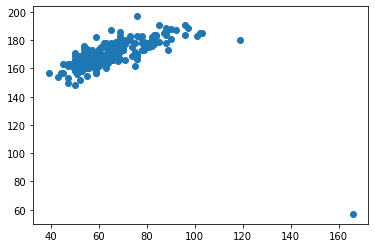

In [290]:
x = davis[['weight', 'height']]

plt.plot(x.weight, x.height, 'o');

In [291]:
ath = chi2.ppf(0.99, df=1)

mx = np.mean(x, axis=0)
Xc = x - mx
Sx = Xc.T @ Xc / len(x)

a = np.sum(Xc * np.matrix(np.linalg.inv(Sx)@Xc.T).T, axis=1)

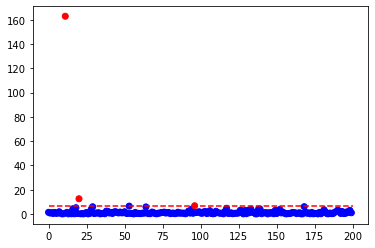

In [292]:
# 閾値の決定
ath = chi2.ppf(0.99, df=1)

# 最尤推定値の計算
mx = np.mean(x, axis=0) # 平均値
Xc = x - mx
Sx = Xc.T @ Xc / len(x) # 分散

# 異常度の計算
a = np.sum(Xc * np.matrix(np.linalg.inv(Sx)@Xc.T).T, axis=1)

plt.scatter(np.arange(len(x)), a, color = ['red' if a > ath else 'blue' for a in a]);
plt.hlines(ath, xmin=0, xmax=200, linestyles='--', color='red');

### 6. マハラノビス=タグチ法
ホテリング理論で計算されるのは全系の総合的な異常度であり、個別の異常度ではなかった。  
この課題に対応するものとして**マハラノビス=タグチ法(MT法)**がある。  

>手順2 (マハラノビス=タグチ法)  
>1. 分布推定　$D$を基に、標本平均と標本共分散を求める
>2. 異常度の計算　$D$の中の各標本に対し、1変数当たりのマハラノビス距離を計算する
>3. 異常判定1　$D$の標本が正常範囲に入るように1変数当たりのマハラノビス距離の閾値を求める
>4. 異常判定2　$D'$の各標本に対して、$M$変数の中からいくつかの変数を選び、その変数集合の1変数当たりの異常度を計算する

変数集合$q$に対するSN比を,
$$
SN_q=-10\log_{10}\biggl\{\frac{1}{N'}\sum_{n=1}^{N'}\frac{1}{a_q(\boldsymbol{x'}^{(n)})/M_q} \biggr\}
$$
導入する。  
ここで、$q$は変数の取捨選択パターンを区別する添字で、$M_q$はパターン$q$における変数の数、$a_q$はパターン$q$に対応して、$M_q×M_q$次元の共分散行列を使ったときの異常度である。  


In [310]:
road = pd.read_csv('C:/Users/tanak/study/参考書/機械学習による異常検知/road.csv', index_col=0)
road = road.astype(float)
road.head()

,deaths,drivers,popden,rural,temp,fuel
Alabama,968.0,158.0,64.0,66.0,62.0,119.0
Alaska,43.0,11.0,0.4,5.9,30.0,6.2
Arizona,588.0,91.0,12.0,33.0,64.0,65.0
Arkanas,640.0,92.0,34.0,73.0,51.0,74.0
Calif,4743.0,952.0,100.0,118.0,65.0,105.0


In [311]:
# 変数はdrivers(運転者数)で割った値の対数をとったものを使用
x = road.apply(lambda x: x / road['drivers'])
del x['drivers']
x = np.log1p(x)

# 標本平均と標本共分散を求める
mx = np.mean(x)
Xc = x - mx
Sx = Xc.T@Xc/len(x)

# 異常値の計算(マハラノビス距離)
a = np.sum(Xc * np.matrix(np.linalg.inv(Sx)@Xc.T).T/x.shape[1], axis=1)

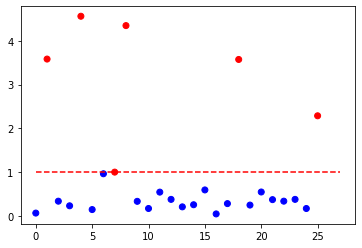

In [312]:
# 変数はdrivers(運転者数)で割った値の対数をとったものを使用
x = road.apply(lambda x: x / road['drivers'])
del x['drivers']
x = np.log1p(x)

# 標本平均と標本共分散を求める
mx = np.mean(x)
Xc = x - mx
Sx = Xc.T@Xc/len(x)

# 異常値の計算(マハラノビス距離)
a = np.sum(Xc * np.matrix(np.linalg.inv(Sx)@Xc.T).T/x.shape[1], axis=1)

plt.scatter(np.arange(len(x)), a, color = ['red' if a > 1 else 'blue' for a in a]);
plt.hlines(1, xmin=0, xmax=27, linestyles='--', color='red');

SN比は、$N'=1,M_q=1$として各変数のSN比を計算する。  
この場合のSN比は非常に簡単になり、
$$
SN_q=10\log_{10}\frac{a_q(\boldsymbol{x'})}{M_q}=10\log_{10}\frac{(x'_q-\hat{\mu}_q)^2}{\hat{\sigma}_q^2}
$$

$\hat{\mu}_q$および$\hat{\sigma}_q^2$はそれぞれ、第$q$番目の変数の標本平均と標本分散である。

In [316]:
xc_prime = Xc.loc['Calif',:]
SN1 = 10*np.log(xc_prime**2 / np.diag(Sx))

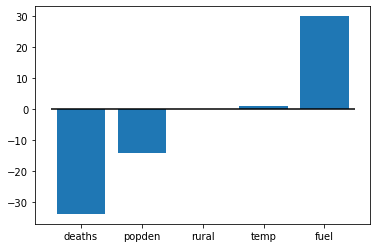

In [324]:
# 対象を選択
xc_prime = Xc.loc['Calif',:]

# SN比の計算
SN1 = 10*np.log(xc_prime**2 / np.diag(Sx))

plt.bar(x=Xc.columns, height=SN1);
plt.hlines(0, xmin=-0.5, xmax=4.5, linestyles='-', color='black');

負のSN比は平均からの偏差が標準偏差よりも小さい場合に生じる。  
Califの大きな異常度はほとんどすべてfuelに帰せられることがわかる。